# astroPIPS tutorial - Basics

In [1]:
import PIPS
import matplotlib.pyplot as plt
import time
import numpy as np

## (0) Data preparation

PIPS takes in an array of 3xN data (samples are available on [github]('https://github.com/SterlingYM/astroPIPS/tree/master/sample_data')) -- time, magnitude (flux), and error on magnitude contained in a single python list or numpy array.
For convenience, photometry data file from [LOSSPhotPipeline]('https://github.com/benstahl92/LOSSPhotPipeline') can be directly imported using a helper function ```data_readin_LPP```.

In [27]:
data = PIPS.data_readin_LPP('../sample_data/002.dat',filter='V')
x,y,yerr = data
print('data shape:\t',np.array(data).shape)
print('x shape:\t',x.shape)
print('y shape:\t',y.shape)
print('y-error shape:\t',yerr.shape)

data shape:	 (3, 103)
x shape:	 (103,)
y shape:	 (103,)
y-error shape:	 (103,)


## (1) Create ```photdata``` object

Most of the functions in ```astroPIPS``` is implemented as atrributes (methods) in ```photdata``` object.

In [28]:
star = PIPS.photdata(data)

## (2-1) Generate periodogram

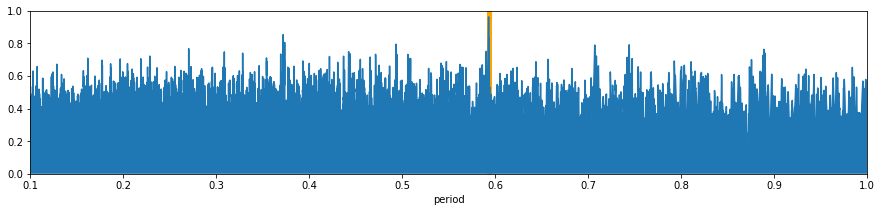

[0.59281761]


In [21]:
# periodogram test
periods,power = star.periodogram(p_min=0.1,p_max=1,multiprocessing=False)

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

## (2-2) Detect main period
```astroPIPS``` is capable of automatically detecting the peak in the periodogram and calculating the uncertainty of the peak value. Doing so is as simple as the following:

In [29]:
# period detection test
star.get_period(multiprocessing=False)

(0.5748866247400108, 7.505536469181548e-06)

The returned tuple contains (period, period error) in the unit of the x-axis in provided data.

## (2-3) Plot the phase-folded light curve

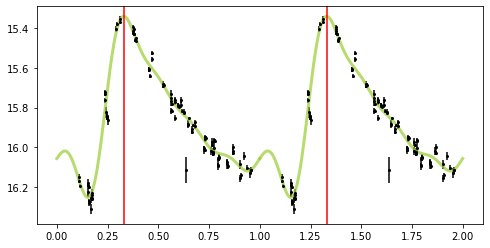

In [13]:
# auto plotting & best-fit curve generation & epoch detection test
star.plot_lc()
x_th,y_th = star.get_bestfit_curve(period=star.period)
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

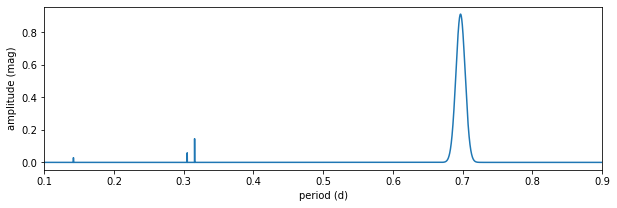

In [8]:
# multi-period detection test
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10,multiprocessing=False)
plt.figure(figsize=(10,3));plt.plot(period,spectrum);plt.xlim(0.1,0.9);plt.xlabel('period (d)');plt.ylabel('amplitude (mag)');plt.show()

## Gaussian Mixture

$$ y_i = \sum_j^K p_j \exp{\left(-\frac{\left[(x_i \mod P)-\mu_j\right]^2}{2\sigma_{y,i}^2}\right)}$$

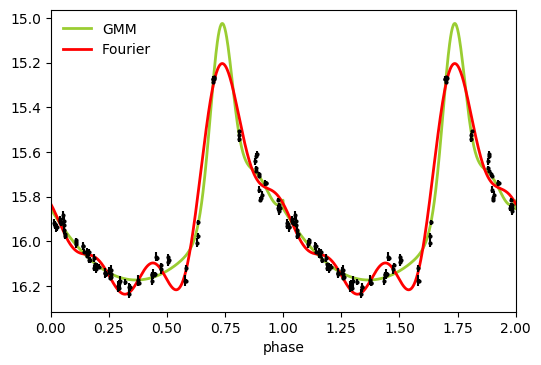

In [8]:
from PIPS.periodogram.models.Gaussian import gaussian, get_bestfit_gaussian
from PIPS.periodogram.models.Fourier import fourier, get_bestfit_Fourier

Nterms = 4
period = star.period
popt_gaussian = get_bestfit_gaussian(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
popt_fourier = get_bestfit_Fourier(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)

x_th = np.linspace(0,period*2,1000)
y_th_gaussian = gaussian(x_th,period,Nterms,np.array(popt_gaussian))
y_th_fourier = fourier(x_th,period,Nterms,np.array(popt_fourier))

plt.figure(dpi=100)
plt.plot(x_th/period,y_th_gaussian,c='yellowgreen',lw=2,zorder=0,label='GMM')
plt.plot(x_th/period,y_th_fourier,c='red',lw=2,zorder=0,label='Fourier')
plt.errorbar(star.x%period/period,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.errorbar(star.x%period/period+1,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.xlabel('phase');plt.xlim(0,2);plt.legend(frameon=False)
plt.gca().invert_yaxis()

In [9]:
Nterms = 3
t0 = time.time()
for _ in range(100):
    popt_fourier = get_bestfit_Fourier(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
print(f'---- {time.time()-t0:.3f} seconds ----')

---- 0.123 seconds ----


In [5]:
t0 = time.time()
for _ in range(100):
    popt_gaussian = get_bestfit_gaussian(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
print(f'---- {time.time()-t0:.3f} seconds ----')

---- 82.149 seconds ----


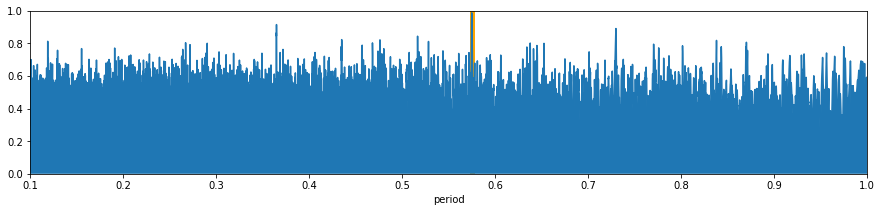

[0.57490775]


In [14]:
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

/Users/Sterling.ym/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


---- 3.862 seconds ----


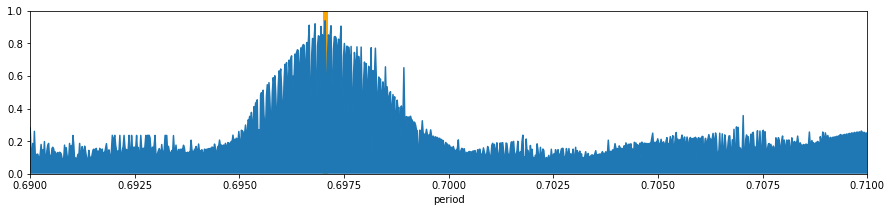

[0.69704705]


In [15]:
# Gaussian periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.69,p_max=0.71,
                                 Nterms=1,N=1000,
                                 method='custom',model='Gaussian',
                                 multiprocessing=False)

print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

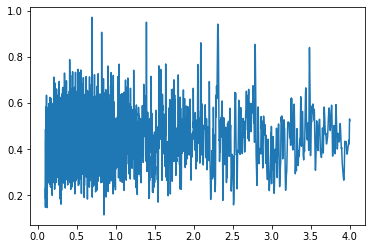

In [22]:
periods_custom,power_custom = star.periodogram(method='custom',model='Fourier',multiprocessing=False)
periods_fast,power_fast = star.periodogram(multiprocessing=False)



In [25]:
star.get_period(method='custom',model='Fourier',multiprocessing=False,debug=True)
star.period

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
18.378s --- detecting top 5 peaks...
18.379s --- preparing for finer sampling near peaks...
18.379s --- performing finer sampling near peaks...
37.074s --- period candidate:  0.6967185028993146
37.077s --- detecting aliasing...
37.077s --- alias factor:  1
37.077s --- period candidate:  0.6967185028993146
37.077s --- estimating the uncertainty...
37.379s --- period candidate:  0.6967185028993146
37.379s --- period fitted*:  0.6968946344582823
37.379s --- period error:  2.285416165778978e-05
37.379s --- refining samples...
37.379s --- refining search width = 6.588e-04
56.135s --- period candidate:  0.6967185028993146
56.136s --- period fitted*:  0.6968946344582823
56.136s --- period error:  2.285416165778978e-05
56.136s --- * validating period error...
56.136s --- * fitted period - peak period = 1.76e-04
56.136s --- * expected deviation size = 2.29e-05
56.136s --- period = 0.696719 +- 0.0

0.6967185028993146

In [26]:
star.get_period(method='fast',model='Fourier',multiprocessing=False,debug=True)
star.period

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
0.509s --- detecting top 5 peaks...
0.510s --- preparing for finer sampling near peaks...
0.511s --- performing finer sampling near peaks...
0.680s --- period candidate:  0.6968901381413386
0.682s --- detecting aliasing...
0.682s --- alias factor:  1
0.682s --- period candidate:  0.6968901381413386
0.682s --- estimating the uncertainty...
0.683s --- period candidate:  0.6968901381413386
0.683s --- period fitted*:  0.6968901381413386
0.683s --- period error:  2.2747483493996766e-05
0.683s --- refining samples...
0.683s --- refining search width = 6.588e-04
0.727s --- period candidate:  0.6968874975991536
0.727s --- period fitted*:  0.6968901381413386
0.727s --- period error:  inf
0.727s --- * validating period error...
0.727s --- * fitted period - peak period = 2.64e-06
0.727s --- * expected deviation size = inf
0.727s --- period = 0.6969 +- 0.0066d
0.727s --- process completed.


0.6968874975991536

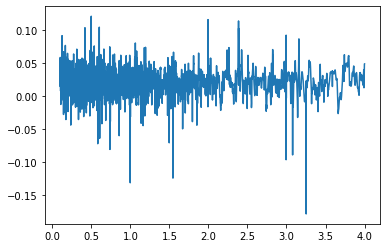

In [23]:
plt.plot(periods_custom,power_custom-power_fast)

---- 0.229 seconds ----


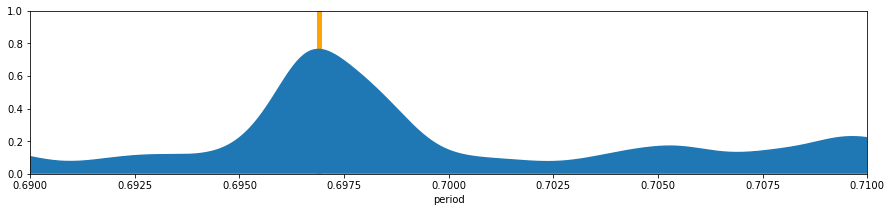

[0.69689379]


In [19]:
# Fourier periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.69,p_max=0.71,
                                 Nterms=1,N=500,
                                 method='custom',model='Fourier',
                                 multiprocessing=False)

print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

(0.68, 0.72)

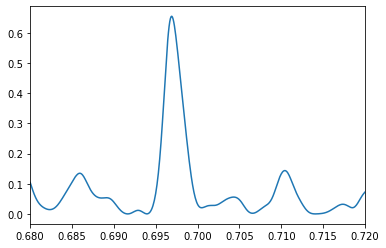

/Users/Sterling.ym/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


---- 1.386 seconds ----


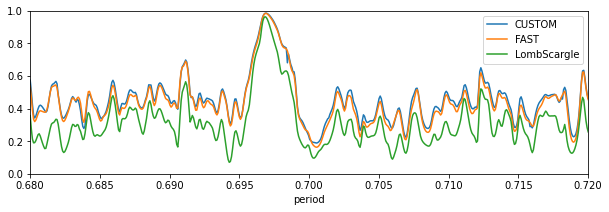

[0.69691383]


In [43]:
# Fourier periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.68,p_max=0.72,
                                 Nterms=5,N=500,
                                 method='custom',model='Fourier',
                                 multiprocessing=False)
periods_fast,power_fast = star.periodogram(p_min=0.68,p_max=0.72,
                                 Nterms=5,N=500,
                                 method='fast',model='Fourier',
                                 multiprocessing=False)
from astropy.timeseries import LombScargle
power_LS = LombScargle(star.x,star.y,nterms=5).power(1/periods)

print(f'---- {time.time()-t0:.3f} seconds ----')



plt.figure(figsize=(10,3))
plt.plot(periods,power,label='CUSTOM')
plt.plot(periods,power_fast,label='FAST')
plt.plot(periods,power_LS,label='LombScargle')
plt.xlabel('period')
plt.xlim(periods.min(),periods.max())
plt.ylim(0,1)
plt.legend()
plt.show()
print(periods[power==power.max()])